Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 327s 700ms/step - accuracy: 0.6947 - loss: 1.2213 - val_accuracy: 0.7332 - val_loss: 0.9514
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 313s 696ms/step - accuracy: 0.7325 - loss: 0.9405 - val_accuracy: 0.7416 - val_loss: 0.8560
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 312s 694ms/step - accuracy: 0.7352 - loss: 0.9246 - val_accuracy: 0.7403 - val_loss: 0.8298
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 313s 695ms/step - accuracy: 0.7448 - loss: 0.8575 - val_accuracy: 0.7468 - val_loss: 0.8278
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 312s 694ms/step - accuracy: 0.7452 - loss: 0.8352 - val_accuracy: 0.7444 - val_loss: 0.7979
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 312s 694ms/step - accuracy: 0.7476 - loss: 0.8184 - val_accuracy: 0.7521 - val_loss: 0.7658
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 311s 691ms/step - accuracy: 0.7494 - loss: 0.8034 - val_accuracy: 0.7488 - val_loss: 0.7765
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 312s 694ms/step - accuracy: 0.7487 -

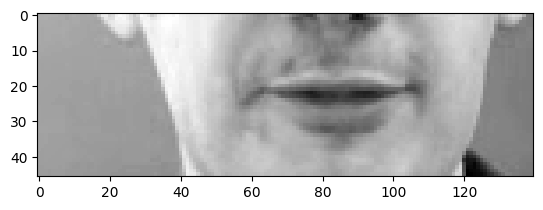

AttributeError: 'str' object has no attribute 'numpy'

In [14]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import StringLookup, Conv3D, MaxPool3D, LSTM, Dense, TimeDistributed, Flatten, Bidirectional, Input, Activation, Dropout
from tensorflow.keras.models import Sequential

# Directory paths
data_dir = "../input/mouth-map-comp/data/s1"
alignment_dir = "../input/mouth-map-comp/data/alignments/s1"

# Define vocabulary
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = StringLookup(vocabulary=vocab, oov_token="")
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

def load_video(path: str):
    """Loads video frames from given path"""
    cap = cv2.VideoCapture(path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        frame = frame[190:236, 80:220]  # Crop ROI
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    cap.release()
    return np.array(frames, dtype=np.float32)

def load_alignments(path: str):
    """Loads text alignments from file"""
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens.extend([' ', line[2]])
    alignments = char_to_num(tf.strings.unicode_split(''.join(tokens), input_encoding='UTF-8'))[1:]
    alignments = tf.pad(alignments, [[0, 75 - tf.shape(alignments)[0]]])  # Ensure shape consistency
    return alignments

def load_data(video_path):
    """Loads both video and alignment"""
    video_path = video_path.numpy().decode('utf-8')  
    file_name = os.path.basename(video_path).split('.')[0]
    align_path = os.path.join(alignment_dir, f'{file_name}.align')
    
    frames = load_video(video_path)
    alignments = load_alignments(align_path)

    # Ensure consistent frame length (Pad if needed)
    if frames.shape[0] < 75:
        pad_size = 75 - frames.shape[0]
        frames = np.pad(frames, ((0, pad_size), (0, 0), (0, 0)), mode='constant')

    # Expand channel dimension
    frames = np.expand_dims(frames, axis=-1)  # Shape: (75, 46, 140, 1)
    
    return frames, alignments

def mappable_function(path: tf.Tensor):
    """TensorFlow mapping function for dataset"""
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    result = (tf.ensure_shape(result[0], [75, 46, 140, 1]), tf.ensure_shape(result[1], [75]))
    return result

# Create TensorFlow Data Pipeline
data = tf.data.Dataset.list_files(os.path.join(data_dir, "*.mpg"))
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

# Adjusted padding shapes
data = data.padded_batch(2, padded_shapes=([75, 46, 140, 1], [75]))  
data = data.prefetch(tf.data.AUTOTUNE)

# Split into Train & Test
train_data = data.take(450)
test_data = data.skip(450)

# Define 3D CNN + LSTM Model
model = Sequential([
    Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same', activation='relu'),
    MaxPool3D((1, 2, 2)),

    Conv3D(256, 3, padding='same', activation='relu'),
    MaxPool3D((1, 2, 2)),

    Conv3D(75, 3, padding='same', activation='relu'),
    MaxPool3D((1, 2, 2)),

    TimeDistributed(Flatten()),

    Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)),
    Dropout(0.5),

    Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)),
    Dropout(0.5),

    Dense(char_to_num.vocabulary_size(), kernel_initializer='he_normal', activation='softmax')
])

# Compile and Train Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_data, validation_data=test_data, epochs=10)

# Save Model
model.save("lip_reading_model.h5")



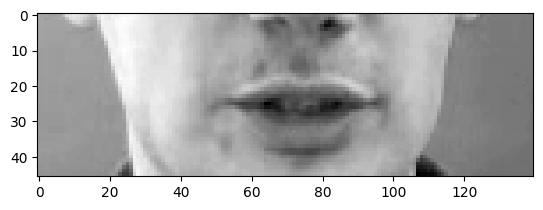

AttributeError: 'str' object has no attribute 'numpy'

In [15]:
# Load and test model
def predict_sentence(video_path):
    """Predicts text from video"""
    frames, actual_alignment = load_data(video_path)
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    predicted_alignment = model.predict(frames)

    # Convert predicted output to text
    predicted_indices = tf.argmax(predicted_alignment, axis=-1)
    predicted_text = tf.strings.reduce_join(num_to_char(predicted_indices)).numpy().decode('utf-8')

    # Convert actual alignment to text
    actual_text = tf.strings.reduce_join(num_to_char(actual_alignment)).numpy().decode('utf-8')

    print(f"Actual: {actual_text}")
    print(f"Predicted: {predicted_text}")

# Sample visualization
frames, alignments = next(iter(data))
plt.imshow(frames[0][35], cmap='gray')
plt.show()

# Test with a sample video
test_video_path = os.path.join(data_dir, "bbaf2n.mpg")
predict_sentence(test_video_path)


In [17]:
def load_data(video_path):
    """Loads both video and alignment"""
    if isinstance(video_path, tf.Tensor):  # Convert tensor to string if needed
        video_path = video_path.numpy().decode('utf-8')

    file_name = os.path.basename(video_path).split('.')[0]
    align_path = os.path.join(alignment_dir, f'{file_name}.align')
    
    frames = load_video(video_path)
    alignments = load_alignments(align_path)

    # Ensure consistent frame length (Pad if needed)
    if frames.shape[0] < 75:
        pad_size = 75 - frames.shape[0]
        frames = np.pad(frames, ((0, pad_size), (0, 0), (0, 0)), mode='constant')

    # Expand channel dimension
    frames = np.expand_dims(frames, axis=-1)  # Shape: (75, 46, 140, 1)
    
    return frames, alignments


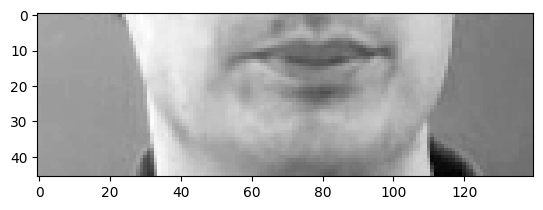

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Actual: bin blue at f three soon
Predicted: pin e ee             o


In [27]:
def predict_sentence(video_path):
    """Predicts text from video"""
    frames, actual_alignment = load_data(video_path)  # No error now
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    predicted_alignment = model.predict(frames)

    # Convert predicted output to text
    predicted_indices = tf.argmax(predicted_alignment, axis=-1)
    predicted_text = tf.strings.reduce_join(num_to_char(predicted_indices)).numpy().decode('utf-8')

    # Convert actual alignment to text
    actual_text = tf.strings.reduce_join(num_to_char(actual_alignment)).numpy().decode('utf-8')

    print(f"Actual: {actual_text}")
    print(f"Predicted: {predicted_text}")


# Sample visualization
frames, alignments = next(iter(data))
plt.imshow(frames[0][35], cmap='gray')
plt.show()

# Test with a sample video
test_video_path = os.path.join(data_dir, "bbaf3s.mpg")
predict_sentence(test_video_path)



In [35]:
from tensorflow.keras.models import load_model

# Load the saved model from Kaggle's output directory
model_path = "/kaggle/working/lip_reading_model.h5"  # Change if saved elsewhere
model = load_model(model_path)

import cv2
import numpy as np
import tensorflow as tf

def preprocess_video(video_path):
    """Loads and preprocesses a video to match the model input format"""
    frames = []

    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Crop ROI
        frame = frame[190:236, 80:220]  # Ensure correct cropping
        
        # Normalize
        frame = frame / 255.0  
        frames.append(frame)

    cap.release()

    # Convert to NumPy array
    frames = np.array(frames, dtype=np.float32)

    # Ensure 75 frames (pad if needed)
    if frames.shape[0] < 75:
        pad_size = 75 - frames.shape[0]
        frames = np.pad(frames, ((0, pad_size), (0, 0), (0, 0)), mode='constant')

    # Expand dimensions to match model input (batch size 1, channel 1)
    frames = np.expand_dims(frames, axis=-1)  # Add channel dim
    frames = np.expand_dims(frames, axis=0)  # Add batch dim

    return frames

def predict_from_saved_model(video_path):
    """Predicts lip reading from a given video using the saved model"""
    frames = preprocess_video(video_path)  # Process video

    # Make prediction
    predicted_alignment = model.predict(frames)
    
    # Get the most likely character indices
    predicted_indices = tf.argmax(predicted_alignment, axis=-1)
    
    # Convert indices to characters
    predicted_text = tf.strings.reduce_join(num_to_char(predicted_indices)).numpy().decode('utf-8')

    print(f"Predicted Text: {predicted_text}")

# Test with a sample video from Kaggle dataset
test_video_path = "/kaggle/input/mouth-map-comp/data/s1/bbbs7a.mpg"  # Change if needed
predict_from_saved_model(test_video_path)





1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicted Text: pin e ee             o


In [38]:
# Evaluate on Train Data
train_loss, train_accuracy = model.evaluate(train_data)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


450/450 ━━━━━━━━━━━━━━━━━━━━ 114s 249ms/step - accuracy: 0.7516 - loss: 0.7554
Train Loss: 0.7469, Train Accuracy: 0.7531
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 247ms/step - accuracy: 0.7492 - loss: 0.7730
Test Loss: 0.7631, Test Accuracy: 0.7523
